<a href="https://colab.research.google.com/github/dhasaf/unity-project1/blob/main/FlightPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Flight price prediction**
### Our goal is to build supervised Natural Language Processing (NLP) machine learning models to predict the price of a flight.

### **Import Libaries**

In [184]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
##from pandas.core.describe import DataFrameDescriber
from sklearn.model_selection import StratifiedShuffleSplit

### **Load the data**

In [185]:
flight = pd.read_csv("Flight_price.csv")
flight.head()

,number,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


### **View data**

In [186]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   number            300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  lead_reservation  300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [187]:
flight.describe()

,number,duration,lead_reservation,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


In [188]:
flight.shape

(300153, 12)

**Check number of null values**

In [189]:
flight.isnull().sum()

number              0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
lead_reservation    0
price               0
dtype: int64

Check duplicates 

In [190]:
flight.duplicated().sum()

0

number of unique data for each feature

In [191]:
flight.nunique()

number              300153
airline                  6
flight                1561
source_city              6
departure_time           6
stops                    3
arrival_time             6
destination_city         6
class                    2
duration               476
lead_reservation        49
price                12157
dtype: int64

As we understand from the result above, the "number" column is an index since its unique values are just like the size of our dataset, which is 300153.
So, it will be dropped from our dataset.

In [192]:
flight.drop(["number"], axis=1, inplace=True)

In [193]:
flight.shape

(300153, 11)

convert price from int to float

In [194]:
flight['price'] = flight['price'].astype(float)

**Draw histogram to view the numeric values distribution**

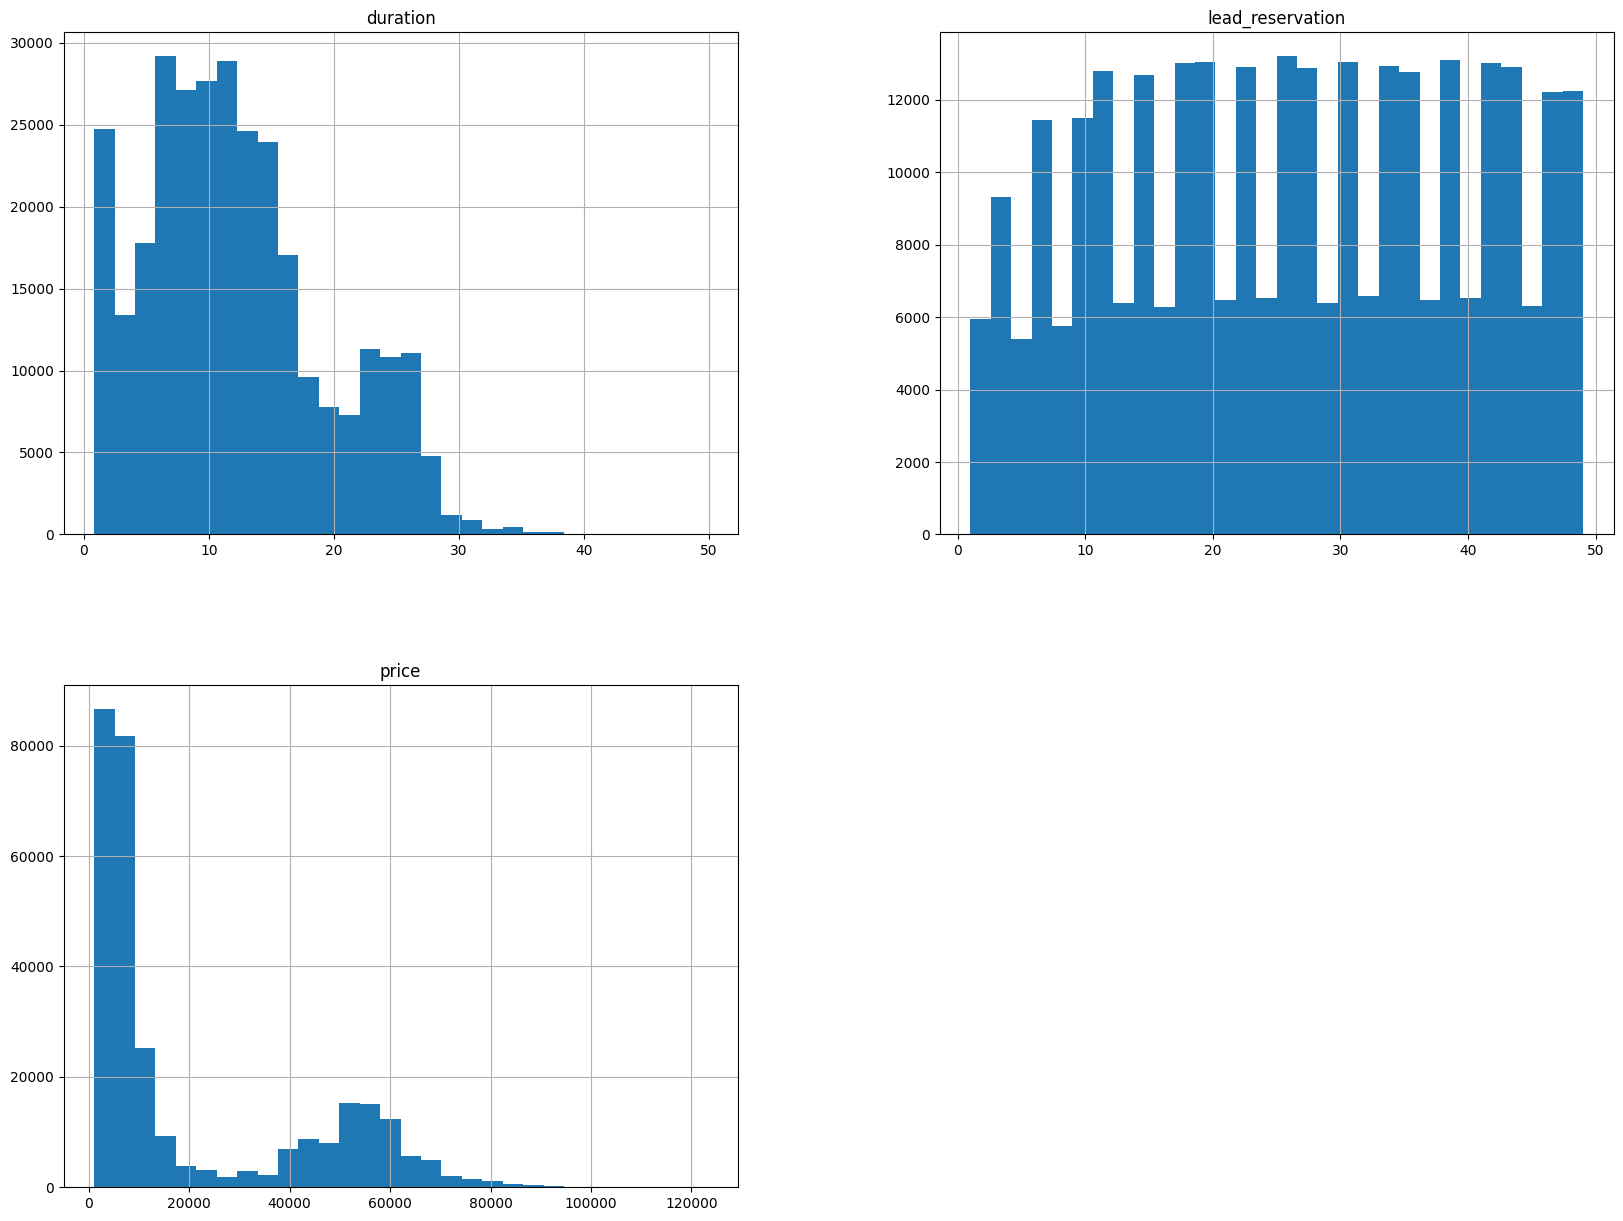

In [195]:
%matplotlib inline
import matplotlib.pyplot as plt
flight.hist(bins=30, figsize=(20,15))
plt.show()

**Transform categorical into numerics**

In [196]:
flight['class'] = flight['class'].map({'Business':0, 'Economy':1})
flight.head(2)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,1,2.17,1,5953.0
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,1,2.33,1,5953.0


In [197]:
#2: two or more stops
flight['stops'] = flight['stops'].map({'zero':0, 'one':1, 'two_or_more':2})
flight.head(2)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,1,2.17,1,5953.0
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,1,2.33,1,5953.0


In [198]:
flight['arrival_time'] = flight['arrival_time'].map({'Early_Morning':0, 'Morning':1, 'Afternoon':2, 'Evening':3, 'Night':4, 'Late_Night':5})
flight.head(2)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,SpiceJet,SG-8709,Delhi,Evening,0,4,Mumbai,1,2.17,1,5953.0
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,1,Mumbai,1,2.33,1,5953.0


In [199]:
flight['departure_time'] = flight['departure_time'].map({'Early_Morning':0, 'Morning':1, 'Afternoon':2, 'Evening':3, 'Night':4, 'Late_Night':5})
flight.head(2)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,lead_reservation,price
0,SpiceJet,SG-8709,Delhi,3,0,4,Mumbai,1,2.17,1,5953.0
1,SpiceJet,SG-8157,Delhi,0,0,1,Mumbai,1,2.33,1,5953.0


**Detect and Remove outliers** 

<Axes: xlabel='duration'>

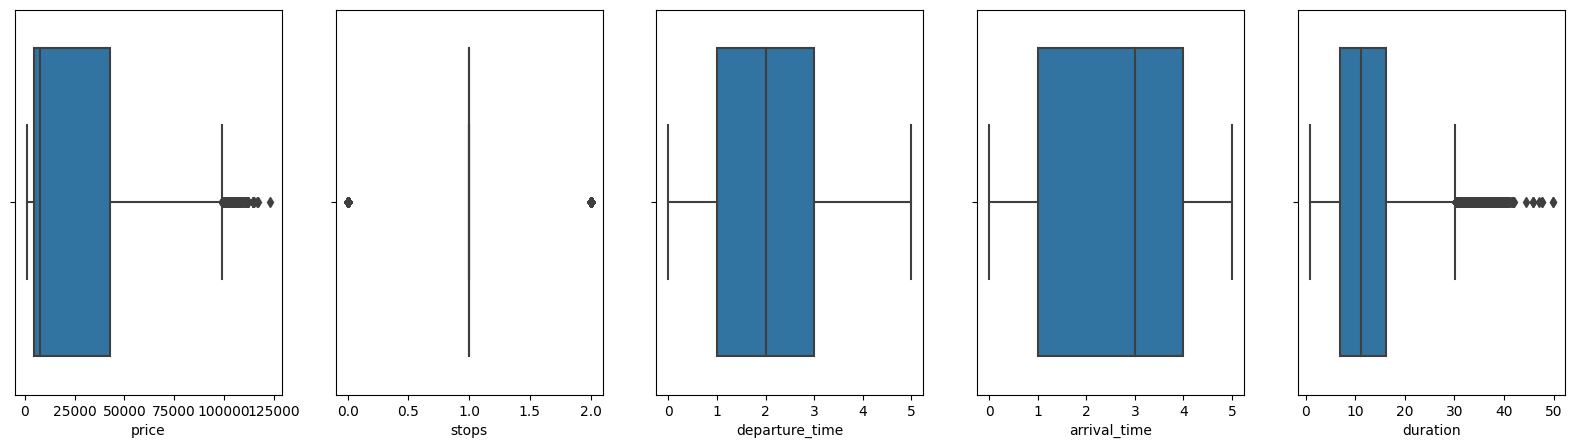

In [200]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['stops'], ax=axs[1])
sns.boxplot(x=flight['departure_time'], ax=axs[2])
sns.boxplot(x=flight['arrival_time'], ax=axs[3])
sns.boxplot(x=flight['duration'], ax=axs[4])

In [201]:
Q1 = flight.quantile(0.25)
Q3 = flight.quantile(0.75)
IQR = Q3 - Q1
flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]

<ipython-input-201-63ea7a9fe649>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  flight = flight[~((flight < (Q1 - 1.5 * IQR)) |(flight > (Q3 + 1.5 * IQR))).any(axis=1)]


<Axes: xlabel='duration'>

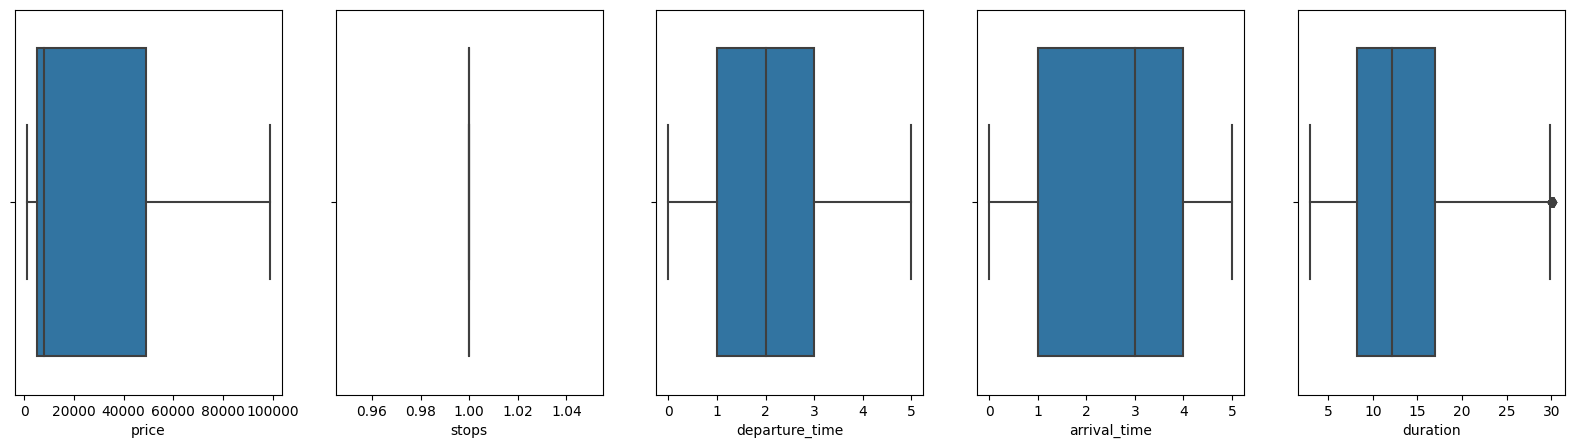

In [202]:
# Create a figure and axes for box plots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,5))

# Draw box plots for each feature
sns.boxplot(x=flight['price'], ax=axs[0])
sns.boxplot(x=flight['stops'], ax=axs[1])
sns.boxplot(x=flight['departure_time'], ax=axs[2])
sns.boxplot(x=flight['arrival_time'], ax=axs[3])
sns.boxplot(x=flight['duration'], ax=axs[4])

we will use the StratifiedShuffleSplit to split the data keeping the same distribution of class category.

<Axes: >

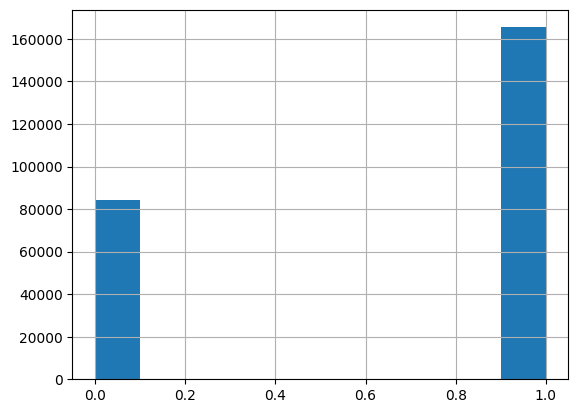

In [203]:
flight["class1"] = pd.cut(flight["class"], bins = [-1,0,1], labels = [0,1])
flight["class1"].hist()

### **Get the size of taining set and test set**

In [204]:
#using Scikit-Learn train_test_split()
train_set, test_set = train_test_split(flight, test_size=0.2, random_state=42)
print("size of training data",len(train_set))
print("size of testing data",len(test_set))

size of training data 199582
size of testing data 49896


In [205]:
split=StratifiedShuffleSplit(n_splits=1 ,test_size=0.2,random_state=42)
for train_index,test_index in split.split(flight,flight["class1"]):
    strat_train_set= flight.loc[train_index]
    strat_test_set = flight.loc[test_index]

KeyError: ignored

In [ ]:
strat_test_set["class1"].value_counts()/ len(strat_test_set)

In [ ]:
strat_train_set["class1"].value_counts()/ len(strat_train_set)

In [ ]:
flight["class1"].value_counts()/ len(data)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("class1", axis=1, inplace=True)

In [ ]:
strat_train_set.info()

**Correlation matrix**

In [ ]:
flight = strat_train_set.copy()
corr_matrix= flight.corr()
corr_matrix["price"].sort_values(ascending=False)

In [ ]:
corr_matrix

In [ ]:
from pandas.plotting import scatter_matrix
attributes=["duration","class","lead_reservation","price"]
scatter_matrix(flight[attributes], figsize=(12,8))